## Predicting Airbnb Listing Prices in Sydney

Predict listed property prices of Airbnb stays based on various Airbnb characteristics and regression models

---

### Initial Data Analysis


In [1]:
import pandas as pd
import numpy as np

#read data into df
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

concat = pd.concat([train, test])

concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2999
Data columns (total 61 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ID                                            10000 non-null  int64  
 1   name                                          9998 non-null   object 
 2   description                                   9846 non-null   object 
 3   neighborhood_overview                         6943 non-null   object 
 4   host_name                                     10000 non-null  object 
 5   host_since                                    10000 non-null  object 
 6   host_location                                 9996 non-null   object 
 7   host_about                                    6110 non-null   object 
 8   host_response_time                            6821 non-null   object 
 9   host_response_rate                            6821 non-null   

---

### Data Cleaning, Missing Observations and Feature Engineering


##### Cleaning Numerical Data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import Counter
from sklearn.impute import KNNImputer

#save ID col
train_ID = train['ID']
test_ID = test['ID']

#drop ID col
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

#clean price col
train['price'] = train['price'].str.replace("$", "")
train['price'] = train['price'].str.replace(",", "").astype('float')

#index set for train and test
train['index'] = 0
test['index'] = 1

#price saved as target variable
y = train['price']

#concat train and test
total = pd.concat([train, test])
total = total.drop(['price'], axis=1)

C:\Users\tozhy\AppData\Local\Temp\ipykernel_3668\4164988355.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['price'] = train['price'].str.replace("$", "")


1. The ID column is saved for submission purposes then dropped as it is not a feature.
2. The price column is cleaned with dollar signs and commas removed, saved as the target variable, then dropped.
3. Training and test sets are joined, and an index column is created for ease of seperation later.
---

In [3]:
#cleaning date
total['host_since'] = pd.to_datetime(total['host_since']).map(dt.datetime.toordinal)
total['first_review'] = pd.to_datetime(total['first_review']).map(dt.datetime.toordinal)
total['last_review'] = pd.to_datetime(total['last_review']).map(dt.datetime.toordinal)

#cleaning bathrooms
total['bathrooms'].replace(['Shared half-bath','Half-bath','Private half-bath'], '0.5', inplace = True)
total['bathrooms'] = total['bathrooms'].str.replace('[^\d.]', '').astype(float)

#host responses cleaned
total['host_response_rate'] = total['host_response_rate'].str.replace("%", "").astype('float')
total['host_acceptance_rate'] = total['host_acceptance_rate'].str.replace("%", "").astype('float')

C:\Users\tozhy\AppData\Local\Temp\ipykernel_3668\3734524934.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  total['bathrooms'] = total['bathrooms'].str.replace('[^\d.]', '').astype(float)


##### For Date:
- Date is converted to an ordinal format : both years and months changed to number of days.

##### For Bathrooms:
1. Sentences that contain "half" are replaced with 0.5.
2. All non-numeric characters are removed and is then converted to float.

##### For Host Interaction Rates:
- Host response and acceptance rates are cleaned by removing the percentage signs and converting to float.

---

**Task 2, Question 2** Create at least 4 new features from existing features which contain multiple items of information, e.g. creating `email`,  `phone`, `reviews`, `jumio`, etc. from feature `host_verifications`.  
(2 marks)

##### Creating New Features from Existing Features

In [4]:
#list most frequent words
counter = Counter()
total['host_verifications'].str.lower().str.split().apply(counter.update)
most_common = counter.most_common(10)
most_common

[("['email',", 9190),
 ("'phone',", 8397),
 ("'jumio',", 6262),
 ("'reviews',", 5686),
 ("'offline_government_id',", 5059),
 ("'government_id',", 3826),
 ("'selfie',", 3234),
 ("'government_id']", 3127),
 ("'identity_manual']", 2573),
 ("'work_email']", 1828)]

In [5]:
#initialise manual dummies
total['email'] = 0
total['phone'] = 0
total['jumio'] = 0
total['reviews'] = 0
total['offline_government_id'] = 0
total['government_id'] = 0
total['selfie'] = 0
total['identity_manual'] = 0
total['work_email'] = 0

#fill manual dummies
total.loc[total['host_verifications'].str.contains('email'), 'email'] = 1
total.loc[total['host_verifications'].str.contains('phone'), 'phone'] = 1
total.loc[total['host_verifications'].str.contains('jumio'), 'jumio'] = 1
total.loc[total['host_verifications'].str.contains('reviews'), 'reviews'] = 1
total.loc[total['host_verifications'].str.contains('offline_government_id'), 'offline_government_id'] = 1
total.loc[total['host_verifications'].str.contains('government_id'), 'government_id'] = 1
total.loc[total['host_verifications'].str.contains('selfie'), 'selfie'] = 1
total.loc[total['host_verifications'].str.contains('identity_manual'), 'identity_manual'] = 1
total.loc[total['host_verifications'].str.contains('work_email'), 'work_email'] = 1

##### For Host Verification:

1. String splitting is used to find the most common verification methods.
2. Dummy features for each unique verification method are then manually created.

---

In [6]:
#list most frequent words
total['amenities'].str.lower().str.split().apply(counter.update)
most_common = counter.most_common(100)
most_common

[('alarm",', 12135),
 ('allowed",', 11714),
 ('and', 11332),
 ('term', 9301),
 ('stays', 9301),
 ('"essentials",', 9283),
 ('"smoke', 9198),
 ("['email',", 9190),
 ('"free', 8971),
 ('"long', 8960),
 ("'phone',", 8397),
 ('"wifi",', 8241),
 ('"iron",', 8168),
 ('"washer",', 8061),
 ('dryer",', 7647),
 ('"hair', 7624),
 ('"shampoo",', 7215),
 ('water",', 7105),
 ('"dedicated', 6984),
 ('on', 6929),
 ('"heating",', 6781),
 ('workspace",', 6710),
 ('"kitchen",', 6528),
 ('["hot', 6381),
 ("'jumio',", 6262),
 ('"dishes', 6227),
 ('silverware",', 6224),
 ('"hangers",', 6095),
 ('"dryer",', 6037),
 ('parking', 5983),
 ('"refrigerator",', 5866),
 ('"tv",', 5775),
 ('"microwave",', 5763),
 ('"private', 5737),
 ('"cooking', 5735),
 ('basics",', 5734),
 ("'reviews',", 5686),
 ('conditioning",', 5675),
 ('"air', 5429),
 ('"bed', 5155),
 ('linens",', 5153),
 ('premises",', 5086),
 ("'offline_government_id',", 5059),
 ('"stove",', 4891),
 ('or', 4859),
 ('"oven",', 4640),
 ('street', 4335),
 ('park

In [7]:
#initialise manual dummies
total['aircon'] = 0
total['entertainment'] = 0
total['parking'] = 0
total['elevator'] = 0
total['backyard'] = 0
total['bbq'] = 0
total['waterfront'] = 0
total['balcony'] = 0
total['gym'] = 0
total['pool'] = 0

#fill manual dummies
total.loc[total['amenities'].str.contains('conditioning'), 'aircon'] = 1
total.loc[total['amenities'].str.contains('wifi|tv'), 'entertainment'] = 1
total.loc[total['amenities'].str.contains('parking'), 'parking'] = 1
total.loc[total['amenities'].str.contains('elevator'), 'elevator'] = 1
total.loc[total['amenities'].str.contains('backyard|patio|garden'), 'backyard'] = 1
total.loc[total['amenities'].str.contains('bbq|grill|stove'), 'bbq'] = 1
total.loc[total['amenities'].str.contains('waterfront|beachfront'), 'waterfront'] = 1
total.loc[total['amenities'].str.contains('balcony'), 'balcony'] = 1
total.loc[total['amenities'].str.contains('gym'), 'gym'] = 1
total.loc[total['amenities'].str.contains('pool'), 'pool'] = 1

In [8]:
total = total.drop(['amenities','host_verifications'], axis = 1)

##### For Amenities:

1. String splitting is used to find most common amenities.
2. Dummy features are manually created for the most expensive amenities that would possibly add value to the property.
3. Amenities and host verifications columns are then dropped.

---

**Task 2, Question 3**: Impute missing values for all features in both training and test datasets.   
(2 marks)

##### Imputing Missing Values

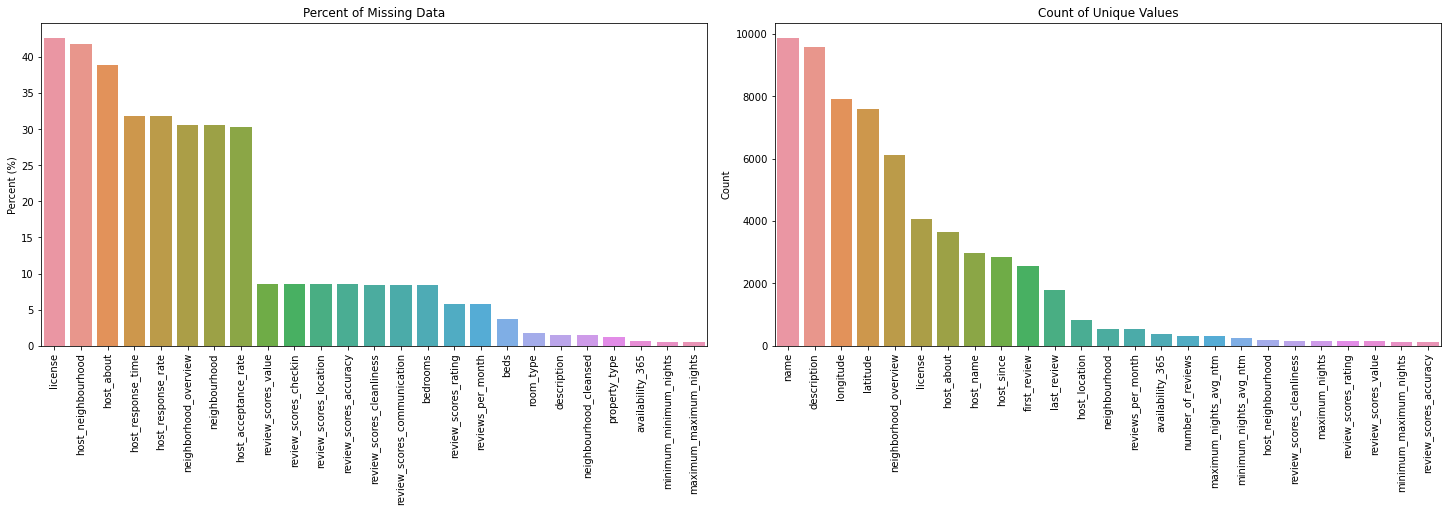

In [9]:
#calculate percent of missing data and sort
missing = (total.isnull().sum() / len(total)) * 100
missing = missing.sort_values(ascending=False).head(25)

#calculate number of unique values and sort
unique = total.nunique()
unique = unique.sort_values(ascending=False).head(25)

#plot
f, ax = plt.subplots(1,2,figsize=(20, 7), constrained_layout=True)

sns.barplot(x=missing.index, y=missing, ax=ax[0])
ax[0].set_ylabel('Percent (%)')
ax[0].set_title('Percent of Missing Data')
ax[0].tick_params(axis='x', labelrotation = 90)

sns.barplot(x=unique.index, y=unique, ax=ax[1])
ax[1].set_ylabel('Count')
ax[1].set_title('Count of Unique Values')
ax[1].tick_params(axis='x', labelrotation = 90)

In [10]:
#dropped due to too many unique or missing values - drop non-nominal features
total = total.drop(['name','description','neighborhood_overview','host_name','host_location','host_about','host_neighbourhood','neighbourhood','license','host_response_rate','host_acceptance_rate','host_response_time'], axis = 1)

##### Dropping Unviable Feature

- The above graphs shows features that have either have too many missing values to impute or too many unique values to split into catergories. These features are dropped.
- Natural Language Processing on the more verbose features was unabled to be implemented due to computational limitations.

---

In [11]:
#grouping related features
room_col = ['beds', 'accommodates','bedrooms','bathrooms']
ratings_col = ['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value']
nights_col = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights','maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm']

#initialising counters for loops
counter1 = 0
counter2 = 0
counter3 = 0

imputer = KNNImputer(n_neighbors=5, weights="uniform")

#extract into arrays and impute
room = total.loc[:,room_col].values
room = imputer.fit_transform(room)

ratings = total.loc[:,ratings_col].values
ratings = imputer.fit_transform(ratings)

nights = total.loc[:,nights_col].values
nights = imputer.fit_transform(nights)

#put back into dataframe
for room_type in room_col:
    total[room_type] = room[:,counter1]
    counter1 = counter1 + 1
    
for ratings_type in ratings_col:
    total[ratings_type] = ratings[:,counter2]
    counter2 = counter2 + 1

for nights_type in nights_col:
    total[nights_type] = nights[:,counter3]
    counter3 = counter3 + 1

##### For Imputing

1. Related features with similar metrics are grouped together.
2. These features are extracted into arrays.
3. A hot deck impuation method is used : K-nearest neighbours - missing values are imputed based on non-missing values of nearest neighbours by Euclidian distance.
4. The extracted arrays are fed back into the concatenated dataframe.

*It is bad practise to impute with training and test sets combined but this approach yielded better results.*

---

C:\Users\tozhy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tozhy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'availability_365')

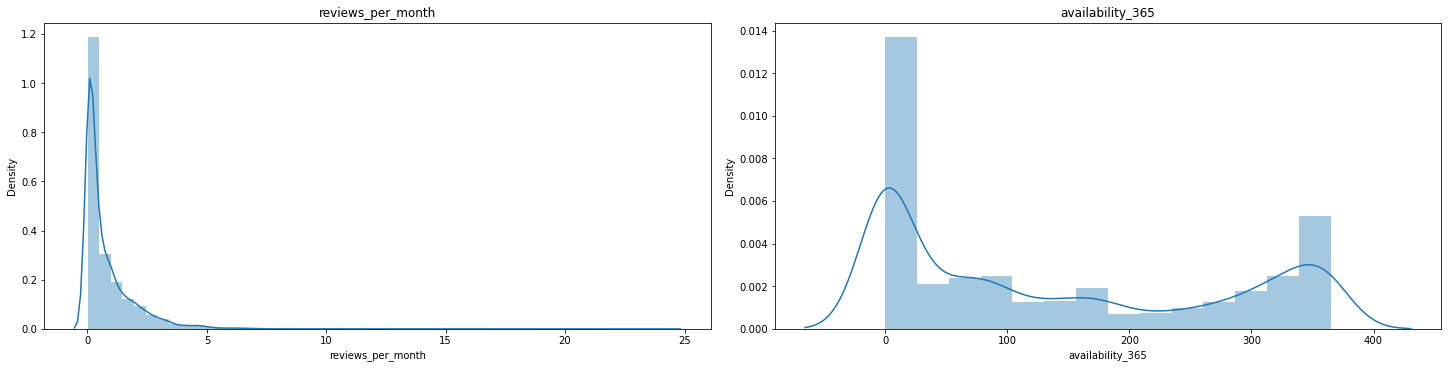

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), constrained_layout=True)

sns.distplot(total['reviews_per_month'], ax=ax[0])
ax[0].set_title('reviews_per_month')
sns.distplot(total['availability_365'], ax=ax[1])
ax[1].set_title('availability_365')

In [13]:
#reviews is skewed
total['reviews_per_month'].fillna(total['reviews_per_month'].median(), inplace=True)

#availability is bimodal
total['availability_365'].fillna(total['availability_365'].mode()[0], inplace=True)

#fill categoricals with "unknown" to avoid bias
total['neighbourhood_cleansed'].fillna("unknown", inplace=True)
total['property_type'].fillna("unknown", inplace=True)
total['room_type'].fillna("unknown", inplace=True)

##### For Remaining Numerical Features:
- Due to skewedness of features, median is used to impute for features that cannot be grouped easily for KNN.
- Bimodal distributions such as in availability are imputed with mode.

##### For Remaining Catergorical Features:
- Catergorical features are imputed with unknown so as to not introduce bias as some features still have significant proportions of missing data.
---

**Task 2, Question 4**: Encode all categorical variables appropriately as discussed in class. 


Where a categorical feature contains more than 5 unique values, map the features into 5 most frequent values + 'other' and then encode appropriately. For instance, you could group then map `property_type` into 5 basic types + 'other': [entire rental unit, private room, entire room, entire towehouse, shared room, other] and then encode.  
(2 marks)

##### Dealing With Features With Too Many Unique Values And Encoding

In [14]:
#top 5 values
total['neighbourhood_cleansed'].value_counts().head(5)

Sydney       2393
Waverley     1157
Randwick      687
Pittwater     553
Manly         491
Name: neighbourhood_cleansed, dtype: int64

In [15]:
#top 5 values
total['property_type'].value_counts().head(5)

Entire rental unit                  4165
Entire residential home             1595
Private room in residential home    1039
Private room in rental unit          952
Entire guest suite                   305
Name: property_type, dtype: int64

In [16]:
#less frequent values replaced with other
total['neighbourhood_cleansed'].replace(['Mosman', 'Ku-Ring-Gai','Leichhardt', 'Warringah', 'Sutherland Shire','Woollahra', 'The Hills Shire', 'Marrickville', 'City Of Kogarah','Lane Cove', 'Canterbury', 'Botany Bay', 'Canada Bay', 'Hornsby','Rockdale', 'Hunters Hill', 'Ryde', 'Auburn', 'Penrith','North Sydney', 'Burwood', 'Willoughby', 'Camden', 'Ashfield','Liverpool', 'Bankstown', 'Blacktown', 'Hurstville', 'Holroyd','Parramatta', 'Campbelltown', 'Strathfield', 'Fairfield'], 'Other', inplace = True)
total['property_type'].replace(['Entire townhouse','Entire bungalow', 'Private room in guesthouse', 'Entire cabin','Entire loft', 'Entire cottage', 'Entire condominium (condo)','Private room in guest suite', 'Private room in loft','Entire guesthouse', 'Entire villa', 'Room in boutique hotel','Private room in farm stay', 'Private room in townhouse','Private room in condominium (condo)', 'Private room in cabin','Entire serviced apartment', 'Room in serviced apartment','Shared room in condominium (condo)', 'Private room in hostel','Farm stay', 'Tiny house', 'Private room in bungalow','Shared room in rental unit', 'Private room in bed and breakfast','Train', 'Private room in villa', 'Boat','Shared room in bed and breakfast', 'Casa particular','Entire place', 'Room in hostel','Private room in serviced apartment', 'Room in aparthotel','Island', 'Room in hotel', 'Shared room in hostel','Shared room in residential home', 'Camper/RV','Shared room in guest suite', 'Room in bed and breakfast','Private room in yurt', 'Shared room in earth house', 'Barn','Earth house', 'Cave', 'Treehouse', 'Bus','Private room in chalet', 'Shared room in townhouse','Private room in tiny house', 'Private room in island', 'Campsite','Private room', 'Houseboat', 'Entire vacation home', 'Dome house','Shared room in villa', 'Shared room in serviced apartment','Private room in pension', 'Private room in casa particular','Private room in cottage', 'Entire home/apt', 'Entire chalet','Shared room in guesthouse', 'Shared room in boutique hotel','Private room in tent', 'Holiday park', 'Private room in tipi'], 'Other', inplace = True)

In [17]:
total = pd.get_dummies(total)

1. Features with too many unique values have their 5 most frequent values identified.
2. All other values are replaced with other.
3. Catergorical features are then encoded with dummy variables.
---

**Task 2, Question 5**: Perform any other actions you think need to be done on the data before constructing predictive models, and clearly explain what you have done.   
(1 marks)

##### Normalisation and Multicolinearity

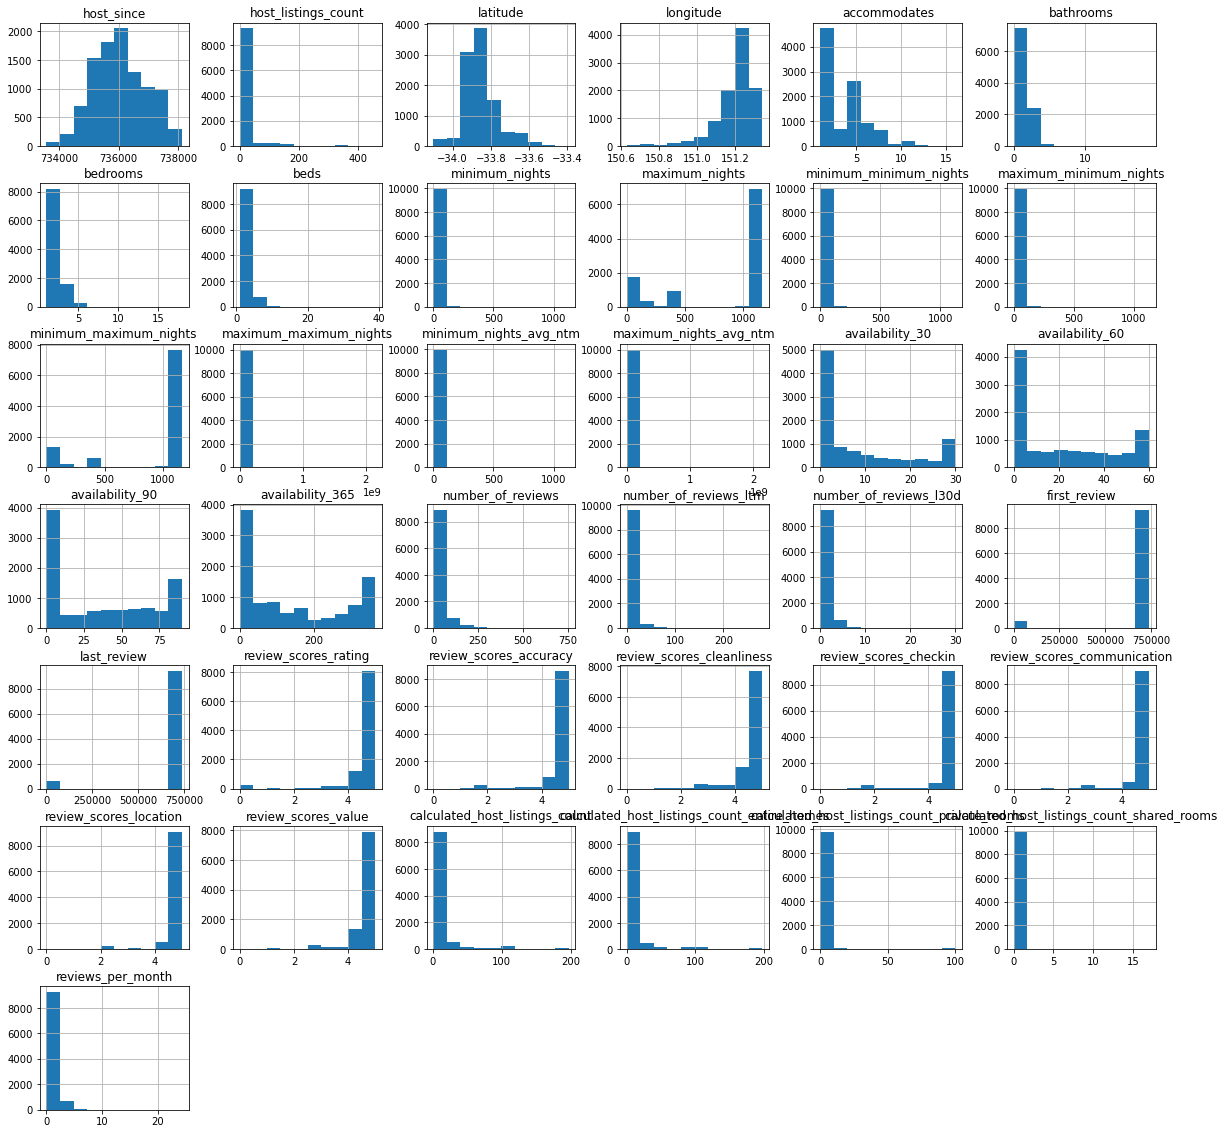

In [18]:
#non-dummy numeric features plotted
total[['host_since', 'host_listings_count', 'latitude', 'longitude','accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights','maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30','availability_60', 'availability_90', 'availability_365','number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d','first_review', 'last_review', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms', 'reviews_per_month']].hist(figsize=(20,20));

In [19]:
#positive skewed features grouped
log_columns = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30','availability_60', 'availability_90', 'availability_365','number_of_reviews','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms', 'reviews_per_month']

#logged to normalise distribution
for col in log_columns:
    total[col] = total[col].astype('float64').replace(0.0, 0.01)
    total[col] = np.log(total[col])

1. From the histograms above, non-dummy numerical features with positive skew identified.
2. These features are log transformed to normalise them - values with 0 are changed to 0.01 to avoid undefined values from log transformation.
---

<AxesSubplot:>

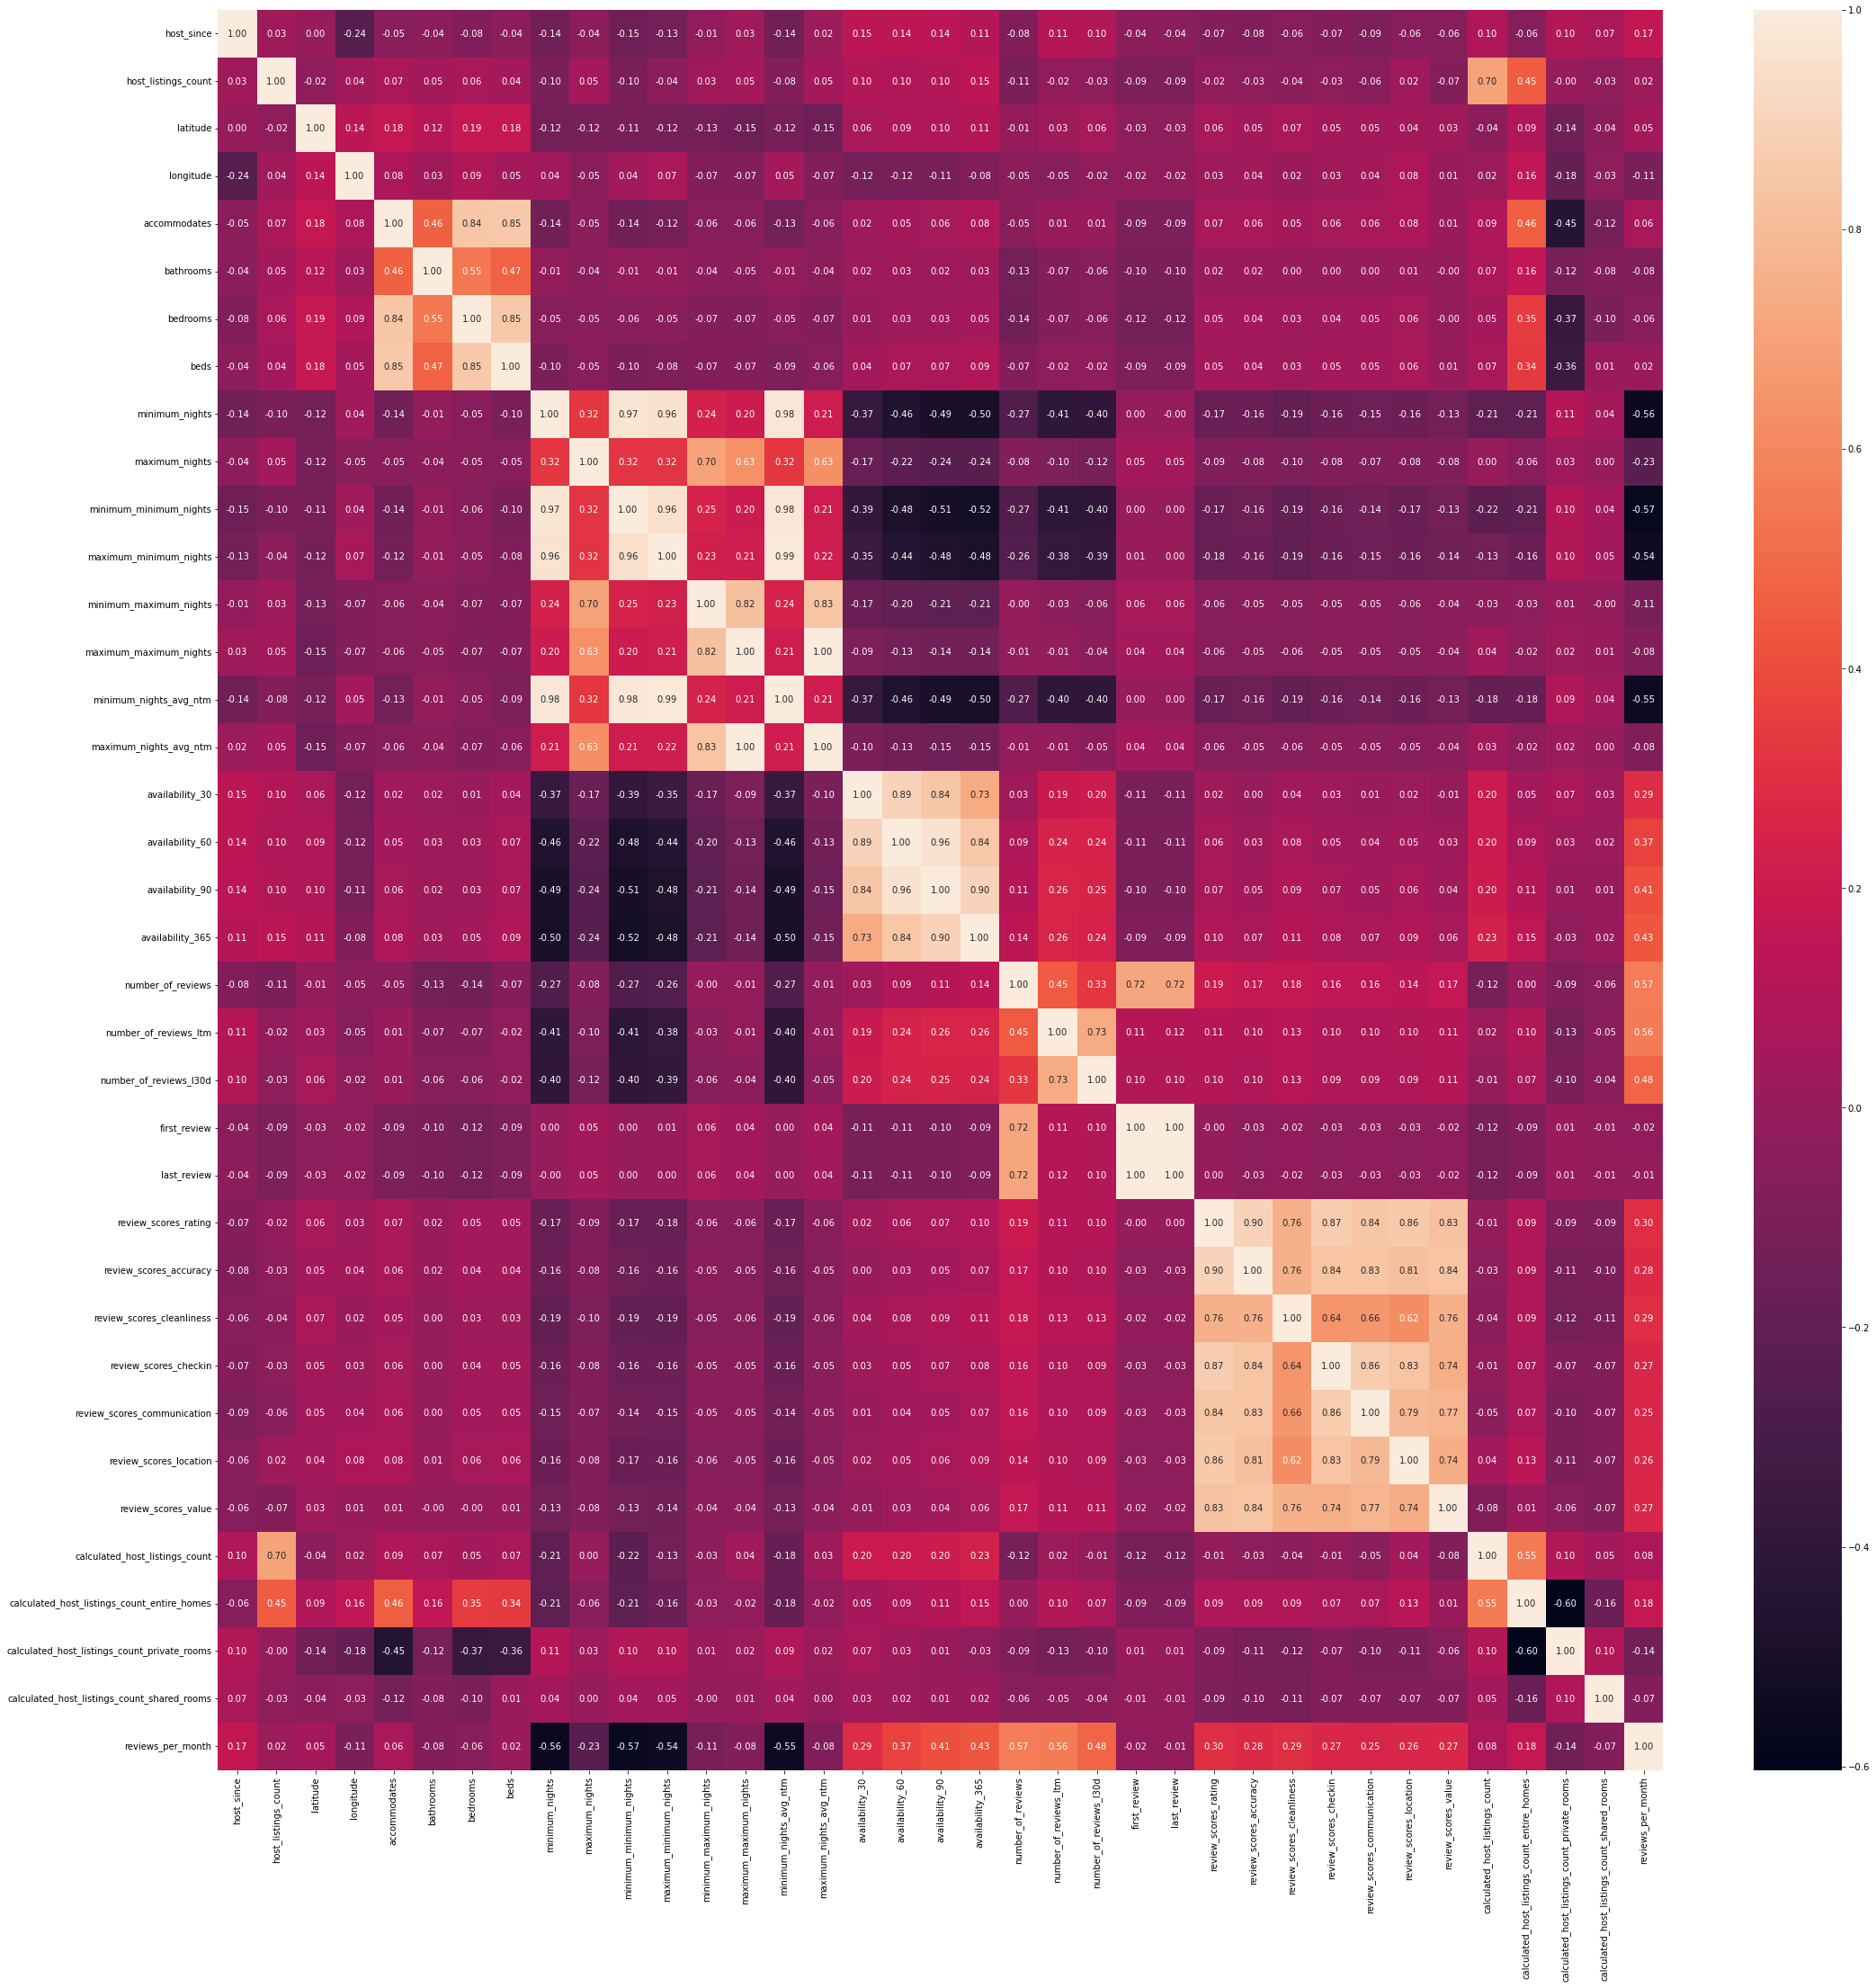

In [20]:
f, ax = plt.subplots(figsize=(36, 36))

sns.heatmap(total[['host_since', 'host_listings_count', 'latitude', 'longitude','accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights','maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30','availability_60', 'availability_90', 'availability_365','number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d','first_review', 'last_review', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms', 'reviews_per_month']].corr(), annot = True, fmt = '.2f')

- There is a high degree of correlation in the related groups of features in the correlation heatmap.
- Ideally these features would be dropped or PCA transformed to avoid multicollinearity.
- However, both approaches yielded significantly poorer results and such plans were abandoned.
---

C:\Users\tozhy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Price distribution')

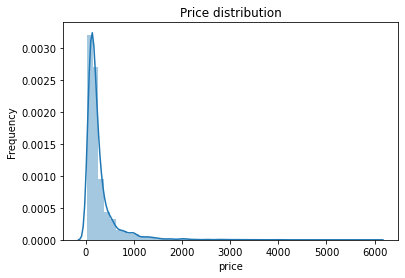

In [21]:
#check price distribution
sns.distplot(y);
plt.ylabel('Frequency')
plt.title('Price distribution')

- Price is positively skewed, this will be addressed later in modeling.
---

**Task 2, Question 6**: Perform exploratory data analysis to measure the relationship between the features and the target and write up your findings. 
(2 marks)

##### Exploratory Data Analysis for Feature Relationship with Price

In [22]:
#seperate the combined 
X = total[total['index'] == 0]
final = total[total['index'] == 1]

X = X.drop('index', axis = 1)
final = final.drop('index', axis = 1)

##### To prepare the data:
- The concatenated data is split back into train and test sets using the index.
- The index column is dropped from both sets.
---

Text(0, 0.5, 'Price')

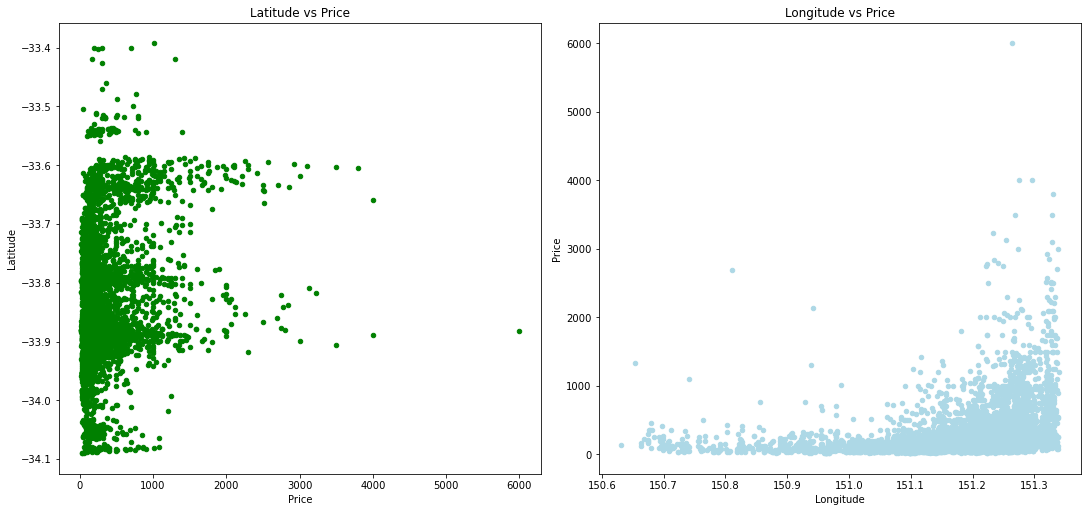

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)

ax[0].scatter(y, X['latitude'], s=20, c='green')
ax[0].set_title('Latitude vs Price')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Latitude')

ax[1].scatter(X['longitude'], y, s=20, c='lightblue')
ax[1].set_title('Longitude vs Price')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Price')

- The latitude and longitutde scatter plots together represent the Greater Sydney region.
- **For the Latitude Graph**: Price appears to increase around major metropolitan areas and drops off the further away from the city. 
    - Prices increase around Sydney city between -33.8 and -33.9.
    - Pricess increase in national parks around -33.7.
    - The large gaps in data points are assumed to be rivers, such as Broken Bay at -33.6.
- **For the Longitute Graph**: Price increases towards the east, therefore prices are higher on the coast, these are perhaps beach or water front properties.
---

Text(0, 0.5, 'Price')

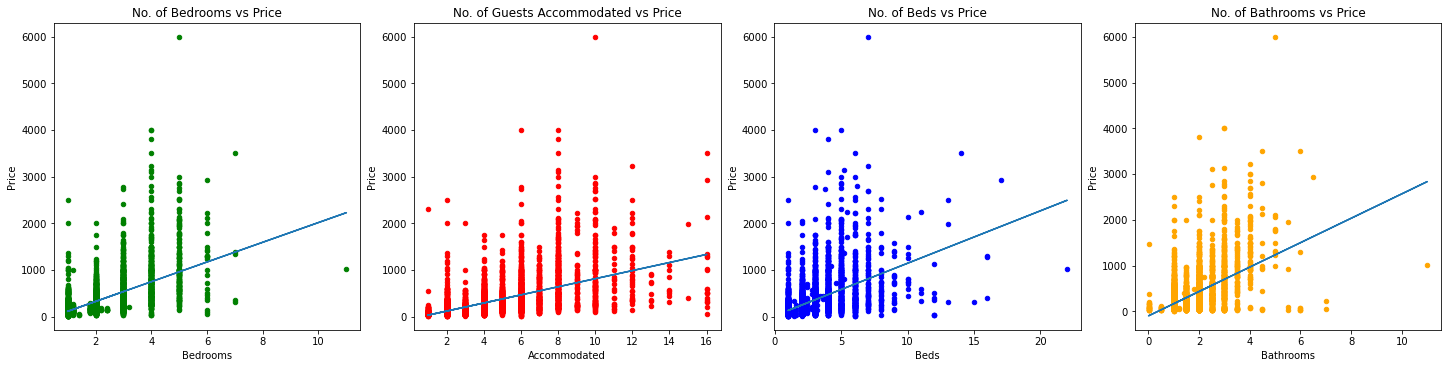

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

ax[0].scatter(np.exp(X['bedrooms']), y, s=20, c='green')
m, b = np.polyfit(np.exp(X['bedrooms']), y, 1)
ax[0].plot(np.exp(X['bedrooms']), m*np.exp(X['bedrooms']) + b)
ax[0].set_title('No. of Bedrooms vs Price')
ax[0].set_xlabel('Bedrooms')
ax[0].set_ylabel('Price')

ax[1].scatter(np.exp(X['accommodates']), y, s=20, c='red')
m, b = np.polyfit(np.exp(X['accommodates']), y, 1)
ax[1].plot(np.exp(X['accommodates']), m*np.exp(X['accommodates']) + b)
ax[1].set_title('No. of Guests Accommodated vs Price')
ax[1].set_xlabel('Accommodated')
ax[1].set_ylabel('Price')

ax[2].scatter(np.exp(X['beds']), y, s=20, c='blue')
m, b = np.polyfit(np.exp(X['beds']), y, 1)
ax[2].plot(np.exp(X['beds']), m*np.exp(X['beds']) + b)
ax[2].set_title('No. of Beds vs Price')
ax[2].set_xlabel('Beds')
ax[2].set_ylabel('Price')

ax[3].scatter(np.exp(X['bathrooms']), y, s=20, c='orange')
m, b = np.polyfit(np.exp(X['bathrooms']), y, 1)
ax[3].plot(np.exp(X['bathrooms']), m*np.exp(X['bathrooms']) + b)
ax[3].set_title('No. of Bathrooms vs Price')
ax[3].set_xlabel('Bathrooms')
ax[3].set_ylabel('Price')

##### Accomodations
- As the correlation is hard to see is the scatterplots, a linear regression line is plotted.
- The trends is the same with all features : price increases with more rooms or people accommodated.
---

--- 
### Fit and tune a forecasting model

In [25]:
#!pip install bayesian-optimization
#!pip install lightgbm
#!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LogisticRegression

C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


##### Importing Regressors
- **IMPORTANT** : Run the above commented out commands if any library is missing.
---

In [26]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#scaling
scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=list(X_train.columns))
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))

#scaling whole set with X_train yields better results
final = pd.DataFrame(scaler.transform(final), columns=list(final.columns))
X = pd.DataFrame(scaler.transform(X), columns=list(X.columns))

##### Feature Scaling
1. The training dataset is split into training(subset) and test(subset) sets for model comparisons, selection and hyperparameter tuning.
2. StandardScaler is fitted to training(subset) set and used to scale both training and test sets.
3. StandardScaler is fitted to training(subset) set and also used to scale the full training set and the final test set.
---

In [27]:
#list of regressors created
regressors= {
    "XGBRegressor": XGBRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "Ridge":Ridge(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
}

df_models = pd.DataFrame(columns=['model', 'rmse'])

#rank regressors by rmse
for i in regressors:

    reg = regressors[i]
    model = reg.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    row = {'model': i,
           'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    }

    df_models = df_models.append(row, ignore_index=True)
    
df_models.sort_values(by='rmse', ascending=True)

C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Local\Temp\ipykernel_3668\4154963562.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\tozhy\AppData\Local\Temp\ipykernel_3668\4154963562.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\tozhy\AppData\Local\Temp\ipykernel_3668\4154963562.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models

,model,rmse
2,RandomForestRegressor,226.243547
1,LGBMRegressor,227.388433
0,XGBRegressor,238.247517
6,Ridge,278.323372
7,BayesianRidge,278.593193
8,ElasticNet,283.915801
3,DecisionTreeRegressor,285.877595
5,SVR,362.896673
4,GaussianProcessRegressor,467.186151


##### Regressor Selection
1. A list of all the regressors are created.
2. The regressors are ranked by minimum RMSE.
3. There is a significant increase in RMSE after XGBoost, therefore LightGBM, XGBoost and RandomForest will be used.
---

In [28]:
#create black box function for XGBoost
def xgb_evaluate(learning_rate, max_depth, n_estimators, subsample, gamma, scale_pos_weight, reg_alpha, reg_lambda):
    model = XGBRegressor(n_jobs = 16,
                         learning_rate = learning_rate,
                         objective = 'reg:squarederror',
                         max_depth = int(max_depth),
                         n_estimators = int(n_estimators),
                         subsample = subsample,
                         gamma = gamma,
                         scale_pos_weight = scale_pos_weight,
                         reg_alpha = reg_alpha,
                         reg_lambda = reg_lambda, random_state=1)
    
    cv = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = sum(cv) / len(cv)  
    
    return rmse

#create black box function for LightGBM
def lgb_evaluate(learning_rate, num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf, min_sum_hessian_in_leaf):
    model = LGBMRegressor(n_jobs = 16,
                         learning_rate = learning_rate,
                         objective = 'regression',
                         num_leaves = int(num_leaves),
                         feature_fraction = feature_fraction,
                         bagging_fraction = bagging_fraction,
                         max_depth = int(max_depth),
                         max_bin = int(max_bin),
                         min_data_in_leaf = int(min_data_in_leaf),
                         min_sum_hessian_in_leaf = int(min_sum_hessian_in_leaf),
                              random_state=1,
                         verbose = -100)
    
    cv = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = sum(cv) / len(cv) 
    
    return rmse

#create black box function for random forest
def rf_evaluate(n_estimators, min_samples_split, min_samples_leaf):
    model = RandomForestRegressor(n_jobs = 16,
                                  n_estimators = int(n_estimators),
                                  min_samples_split = int(min_samples_split),
                                  min_samples_leaf = int(min_samples_leaf),
                                  random_state=1)
                                    
    y_pred = model.fit(X_train_scaled, y_train).predict(X_test_scaled)

    return -1.0 * np.sqrt(mean_squared_error(y_test, y_pred))

##### Black Box Functions
- A Black box functions is created for each regressor for their selected parameters.
- The functions return the negative average RMSE after 5 fold cross valiation of their respective regressor. This is because the Bayesian Optimization function maximises the returned value.
- Random forest does not use cross validation due to computational limitations.
---

##### Hyperparameter Tuning (see below)
- In the interest of time, an informed search method is used : Bayesian Optimization.
- A low number of iterations is used for demonstration purposes.

In [29]:
rfr_bo = BayesianOptimization(rf_evaluate, {'n_estimators' : (1, 1000),
                                             'min_samples_split' : (2, 5),
                                             'min_samples_leaf' : (1, 5)})
                              
# init_points=20, n_iter=100 for final pred
rfr_bo.maximize(init_points=1, n_iter=3, acq='ei')

|   iter    |  target   | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -229.0    |  4.792    |  3.112    |  479.2    |
|  2        | -226.9    |  1.773    |  4.476    |  602.2    |
|  3        | -226.9    |  1.796    |  4.914    |  601.6    |
|  4        | -229.7    |  5.0      |  5.0      |  681.0    |


In [30]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'learning_rate' : (0.05, 0.15),
                                             'max_depth' : (4, 7),
                                             'n_estimators' : (300, 600),
                                             'subsample' : (0.75, 1.0),
                                             'gamma' : (0.15, 0.3),
                                             'scale_pos_weight' : (0, 1),
                                             'reg_alpha' : (0.4, 0.6),
                                             'reg_lambda' : (0.3, 0.5)})
                              
# init_points=10, n_iter=50 for final pred
xgb_bo.maximize(init_points=1, n_iter=3, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

|  1        | -191.7    |  0.2994   |  0.08943  |  4.511    |  436.8    |  0.4032   |  0.3895   |  0.976    |  0.9581   |


C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

|  2        | -193.2    |  0.1766   |  0.1164   |  6.631    |  560.6    |  0.4692   |  0.4824   |  0.8865   |  0.8838   |


C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

|  3        | -190.8    |  0.2402   |  0.09811  |  5.198    |  437.1    |  0.4308   |  0.3611   |  0.9677   |  0.8676   |


C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

|  4        | -191.1    |  0.261    |  0.1023   |  5.271    |  437.4    |  0.5843   |  0.4483   |  0.6257   |  0.8294   |


In [31]:
lgb_bo = BayesianOptimization(lgb_evaluate, {'learning_rate' : (0.1, 0.2),
                                             'num_leaves': (80, 100),
                                             'feature_fraction': (0.5, 0.7),
                                             'bagging_fraction': (0.7, 0.9),
                                             'max_depth': (70, 90),
                                             'max_bin':(60,80),
                                             'min_data_in_leaf': (40, 60),
                                             'min_sum_hessian_in_leaf':(8,10)})
                              
# init_points=10, n_iter=50 for final pred
lgb_bo.maximize(init_points=1, n_iter=3, acq='ei')

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.5799745923685559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5799745923685559
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.7814258907947264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7814258907947264
[LightGBM] [Warning] feature_fraction is set=0.5799745923685559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5799745923685559
[LightGBM] [Warning] min_data_in_leaf is se

In [32]:
#print optimal hyperparameters
print("Model 1: ", xgb_bo.max, "\n")
print("Model 2: ", lgb_bo.max, "\n")
print("Model 3: ", rfr_bo.max, "\n")

Model 1:  {'target': -190.82971090924303, 'params': {'gamma': 0.24016063123361445, 'learning_rate': 0.09810900704939364, 'max_depth': 5.1981431006524295, 'n_estimators': 437.10092936711266, 'reg_alpha': 0.430755972639114, 'reg_lambda': 0.36105684878986466, 'scale_pos_weight': 0.9676534630410969, 'subsample': 0.8675862058570357}} 

Model 2:  {'target': -189.38276083212108, 'params': {'bagging_fraction': 0.8992594728792103, 'feature_fraction': 0.5635333401303445, 'learning_rate': 0.11888645756390451, 'max_bin': 70.72757073362581, 'max_depth': 89.16559556143187, 'min_data_in_leaf': 51.16662713495565, 'min_sum_hessian_in_leaf': 9.653233825290872, 'num_leaves': 88.05450627046358}} 

Model 3:  {'target': -226.93878903234616, 'params': {'min_samples_leaf': 1.7729443348207008, 'min_samples_split': 4.475570130063269, 'n_estimators': 602.2195093624144}} 



In [33]:
#optimised hyperparameters

model1 = XGBRegressor(n_jobs = 16,
                      learning_rate = 0.12486911408592077,
                      objective = 'reg:squarederror',
                      max_depth = int(5.639493175441103),
                      n_estimators = int(386.3358771265735),
                      subsample = 0.7703718340563347,
                      gamma = 0.2353314355905976,
                      scale_pos_weight = 0.012040270339480408,
                      reg_alpha = 0.4890033278297845,
                      reg_lambda = 0.34022556439847196,
                      random_state=1)

model2 = LGBMRegressor(n_jobs = 16,
                       objective = 'regression',
                       learning_rate = 0.14642163924391655,
                       num_leaves = int(49.5856447405978),
                       feature_fraction = 0.5448013972435433,
                       bagging_fraction = 0.9965752931587424,
                       max_depth = int(6.036433619266083),
                       max_bin = int(48.14271196561058),
                       min_data_in_leaf = int(27.189560934082998),
                       min_sum_hessian_in_leaf = int(7.743150418121659),
                       random_state=1)

model3 = RandomForestRegressor(n_jobs = 16,
                               n_estimators = int(858.4211043581138),
                               min_samples_split = int(3.518438549365938),
                               min_samples_leaf = int(2.0590197816135074),
                               random_state=1)


model1_log = XGBRegressor(n_jobs = 16,
                      learning_rate = 0.19287498249468016,
                      objective = 'reg:squarederror',
                      max_depth = int(6.020727852077686),
                      n_estimators = int(797.033969653598),
                      subsample = 0.6094701140613166,
                      gamma = 0.1123638652936445,
                      scale_pos_weight = 0.5878925460451768,
                      reg_alpha = 0.40772874609903154,
                      reg_lambda = 0.5983878729981638,
                      random_state=1)

model2_log = LGBMRegressor(n_jobs = 16,
                       objective = 'regression',
                       learning_rate = 0.1360500735536193,
                       num_leaves = int(43.55499263482596),
                       feature_fraction = 0.6785905966773014,
                       bagging_fraction = 0.18425981775608316,
                       max_depth = int(61.17999290241633),
                       max_bin = int(43.02815274235332),
                       min_data_in_leaf = int(26.95394026626703),
                       min_sum_hessian_in_leaf = int(5.77549911783531),
                       random_state=1)

model3_log = RandomForestRegressor(n_jobs = 16,
                               n_estimators = int(363.0016114768208),
                               min_samples_split = int(5.0),
                               min_samples_leaf = int(1),
                               random_state=1)

##### Regressors
- The optimal hyperparameter are identified for each regressor with target untouched.
- The optimal hyperparameter are identified for each regressor with log transformed target.
- BayesianOptimization gives different results each run so hyperparameter are hardcoded.
---

In [34]:
#non-normal target feature
y_pred1 = model1.fit(X_train_scaled, y_train).predict(X_test_scaled)
y_pred2 = model2.fit(X_train_scaled, y_train).predict(X_test_scaled)
y_pred3 = model3.fit(X_train_scaled, y_train).predict(X_test_scaled)

#normalised target feature by log transformation
y_pred1_log = np.exp(model1_log.fit(X_train_scaled, np.log(y_train)).predict(X_test_scaled))
y_pred2_log = np.exp(model2_log.fit(X_train_scaled, np.log(y_train)).predict(X_test_scaled))
y_pred3_log = np.exp(model3_log.fit(X_train_scaled, np.log(y_train)).predict(X_test_scaled))

C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[LightGBM] [Warning] feature_fraction is set=0.5448013972435433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5448013972435433
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.9965752931587424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965752931587424


C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[LightGBM] [Warning] feature_fraction is set=0.6785905966773014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6785905966773014
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.18425981775608316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18425981775608316


##### Train Regressors
- Each regressor is trained and fitted for testing and comparison.
- 2 sets of predictions are made, one set with log transformed (normalised) target variable price, another with the non transformed price.
---

Text(0.5, 1.0, 'Feature importances in the Random Forest Regression model')

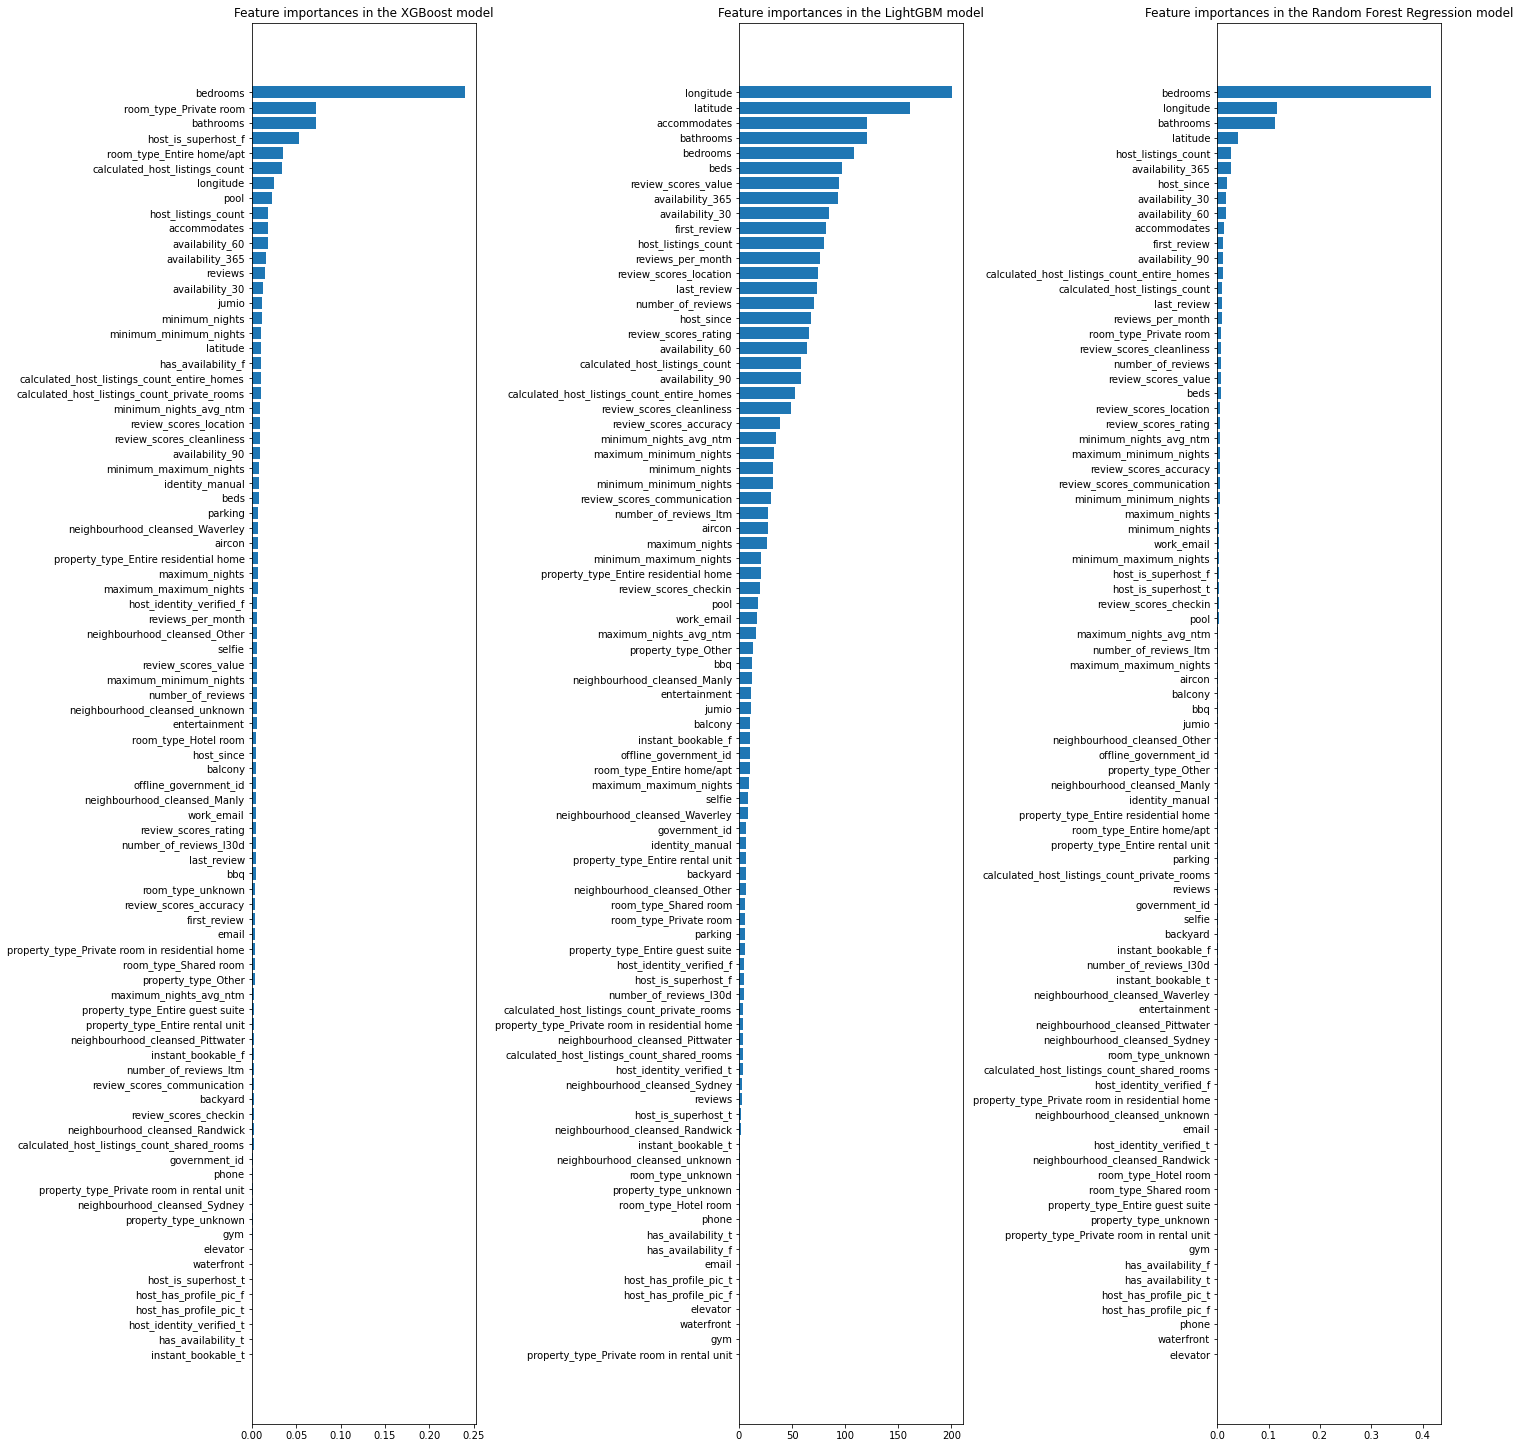

In [35]:
ft_weights1 = pd.DataFrame(model1.feature_importances_, columns=['weight'], index=X_train_scaled.columns)
ft_weights2 = pd.DataFrame(model2.feature_importances_, columns=['weight'], index=X_train_scaled.columns)
ft_weights3 = pd.DataFrame(model3.feature_importances_, columns=['weight'], index=X_train_scaled.columns)

ft_weights1.sort_values('weight', inplace=True)
ft_weights2.sort_values('weight', inplace=True)
ft_weights3.sort_values('weight', inplace=True)

f, ax = plt.subplots(1,3,figsize=(20, 20), constrained_layout=True)

ax[0].barh(ft_weights1.index, ft_weights1.weight, align='center') 
ax[0].set_title("Feature importances in the XGBoost model")

ax[1].barh(ft_weights2.index, ft_weights2.weight, align='center') 
ax[1].set_title("Feature importances in the LightGBM model")

ax[2].barh(ft_weights3.index, ft_weights3.weight, align='center') 
ax[2].set_title("Feature importances in the Random Forest Regression model")

##### Feature Importance
- XGBoost and Random Forest Regression favour number of bedrooms as the most important explanatory feature.
- XGBoost favours accomodation related features such as room type whereas Random Forest Regression favours location a secondary to bedrooms.
- LightGBM favours location as the most important explanatory feature.
---

In [36]:
print("Model 1 (XGBoost): ", np.sqrt(mean_squared_error(y_test, y_pred1)))
print("Model 2 (LightGBM): ", np.sqrt(mean_squared_error(y_test, y_pred2)))
print("Model 3 (RFR): ", np.sqrt(mean_squared_error(y_test, y_pred3)))
print("Model 1 (XGBoost) Normalised: ", np.sqrt(mean_squared_error(y_test, y_pred1_log)))
print("Model 2 (LightGBM) Normalised: ", np.sqrt(mean_squared_error(y_test, y_pred2_log)))
print("Model 3 (RFR) Normalised: ", np.sqrt(mean_squared_error(y_test, y_pred3_log)))


#final model
y_pred_combine = (y_pred1_log+y_pred2_log+y_pred3_log+y_pred1+y_pred2+y_pred3)/6
print("Combined: ", np.sqrt(mean_squared_error(y_test, y_pred_combine)))

Model 1 (XGBoost):  217.00679447632572
Model 2 (LightGBM):  219.07175139338756
Model 3 (RFR):  226.76254967093854
Model 1 (XGBoost) Normalised:  225.1206685643858
Model 2 (LightGBM) Normalised:  226.18545210884125
Model 3 (RFR) Normalised:  241.71561276852168
Combined:  219.3684301385758


##### Model Averaging
- XGBoost without log transformation of price produces the lowest RMSE - therefore theoretically the best model to use. 
- The averaged result of all models produces a lower MSE score (evaluation criterion) on the Kaggle test data set.
---

In [37]:
#create black box function for distribution optimising
def final_evaluate(i, j):
    test_df = pd.DataFrame({
    'price': y_pred_combine
    })

    #outlier manipulation
    q = test_df['price'].quantile(i)
    
    #adjust price distribution
    test_df['price'] = test_df['price'].apply(lambda x: x if x < q else x*j)
    
    #turn any negative values positive
    test_df.loc[test_df['price']<0,'price']=0

    y_pred_test = test_df['price'].values
    
    # negative RMSE for min RSME
    return -1.0 * np.sqrt(mean_squared_error(y_test, y_pred_test))

final_bo = BayesianOptimization(final_evaluate, {'i' : (0.95, 0.999),
                                                 'j' : (1.3, 1.4)})
                              
# init_points=10, n_iter=50 for final pred
final_bo.maximize(init_points=1, n_iter=3, acq='ei')

|   iter    |  target   |     i     |     j     |
-------------------------------------------------
|  1        | -214.1    |  0.9672   |  1.395    |
|  2        | -224.0    |  0.999    |  1.3      |
|  3        | -212.4    |  0.9653   |  1.324    |
|  4        | -213.2    |  0.9636   |  1.305    |


##### Outlier Tuning
- Large outliers produce the biggest errors so they are scaled upwards to minimise MSE (error criterion).
- The optimal quanitle to scale (i) and magnitude of scaling (j) are optimised with Bayesian Optimization again.
- A low number of iterations is used for demonstration purposes.

---

In [38]:
print(final_bo.max)

{'target': -212.39461738080485, 'params': {'i': 0.9653483568365102, 'j': 1.3237691079724487}}


In [39]:
#test
test_df = pd.DataFrame({
    'adjusted': y_pred_combine,
    'control': y_pred_combine
})

#outlier manipulation with optimal parameters
q = test_df['adjusted'].quantile(0.97)
test_df['adjusted'] = test_df['adjusted'].apply(lambda x: x if x < q else x*1.3)
test_df.loc[test_df['adjusted']<0,'adjusted']=0

print("Adjusted RMSE: ", np.sqrt(mean_squared_error(y_test, test_df['adjusted'])),"|  Adjusted R2: ", r2_score(y_test, test_df['adjusted']))
print(" Control RMSE: ", np.sqrt(mean_squared_error(y_test, test_df['control'])),"|   Control R2: ", r2_score(y_test, test_df['control']))

Adjusted RMSE:  210.89803508143874 |  Adjusted R2:  0.6852101209297525
 Control RMSE:  219.3684301385758 |   Control R2:  0.6594162300244983


##### Outlier Tuning
- Outlier scaling produces a better goodness of it (R2) and lower RMSE compared to the unscaled control.
- BayesianOptimization gives different results each run so i and j parameter are hardcoded.

---

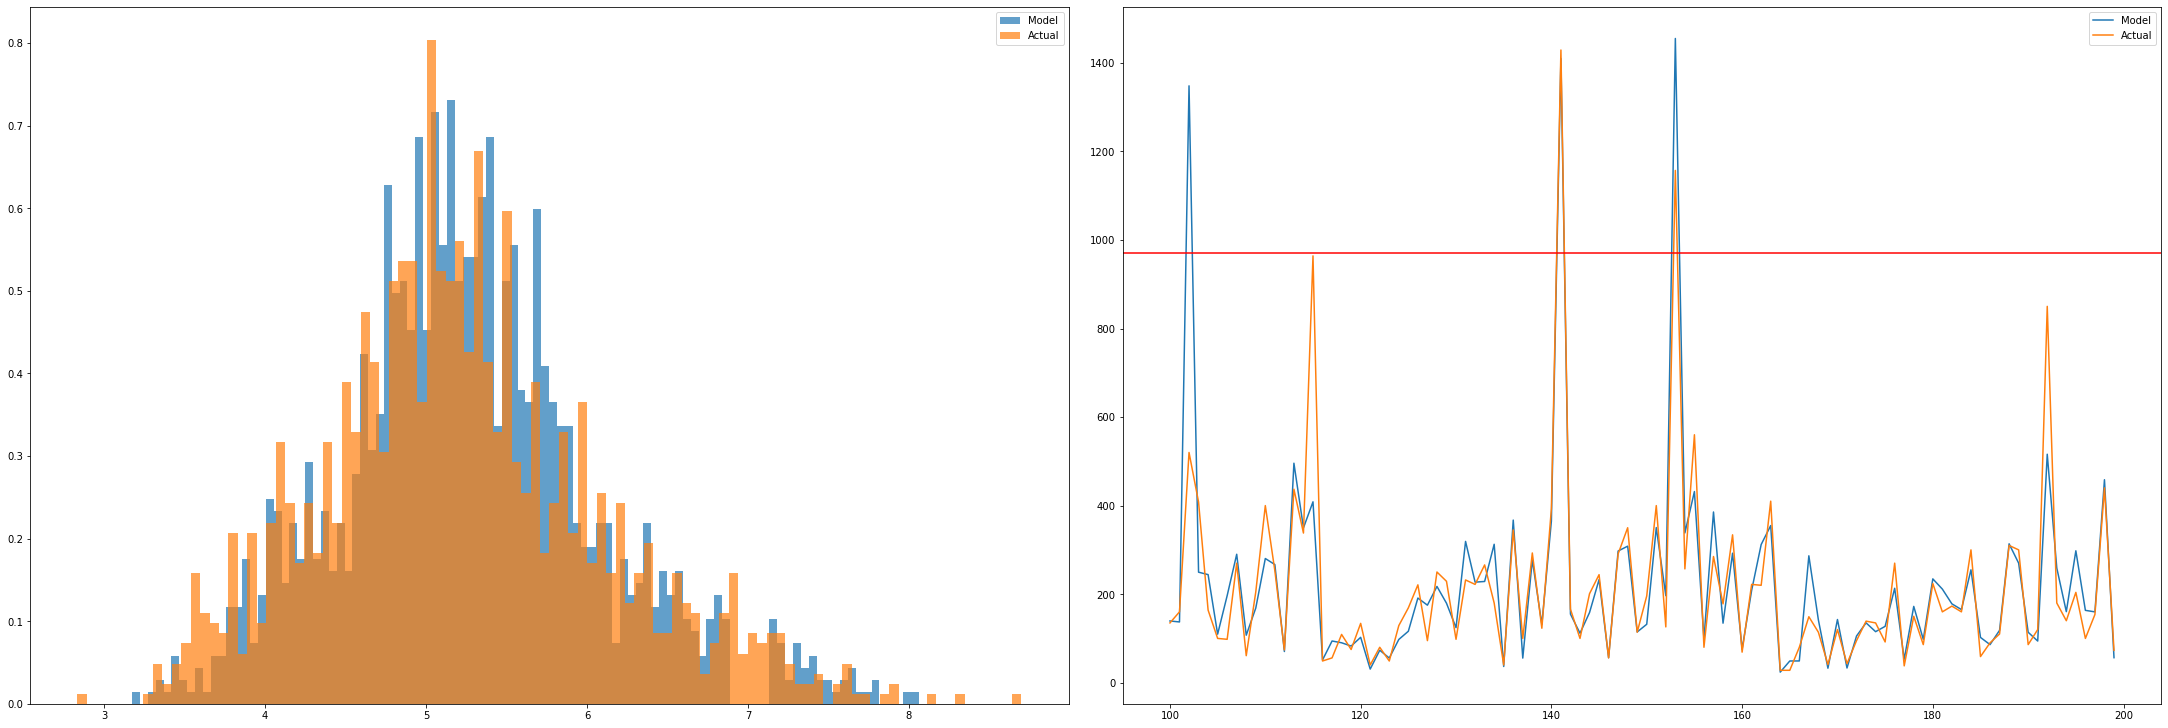

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10), constrained_layout=True)

ax[0].hist(np.log(test_df['adjusted']), density = True, alpha=0.7, label='Model',bins=100)
ax[0].hist(np.log(y_test), density = True, alpha=0.7, label='Actual', bins=100)
ax[0].legend(loc='upper right')

test_df['control'] = y_test.values

ax[1].plot(test_df[100:200])
ax[1].legend(['Model', 'Actual'])
ax[1].axhline(y=q, color='r', linestyle='-')

##### Graphs
- The histogram compares the distribution of the predictions to the test set.
- The line chart compares the distribution of the predictions to the test set.
- The red line represents the 97th percentile, values above this line have been scaled up.
---

In [41]:
y_pred_final1 = model1.fit(X, y).predict(final)
y_pred_final2 = model2.fit(X, y).predict(final)
y_pred_final3 = model3.fit(X, y).predict(final)

y_pred_final_log1 = np.exp(model1_log.fit(X, np.log(y)).predict(final))
y_pred_final_log2 = np.exp(model2_log.fit(X, np.log(y)).predict(final))
y_pred_final_log3 = np.exp(model3_log.fit(X, np.log(y)).predict(final))

C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[LightGBM] [Warning] feature_fraction is set=0.5448013972435433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5448013972435433
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.9965752931587424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965752931587424


C:\Users\tozhy\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[LightGBM] [Warning] feature_fraction is set=0.6785905966773014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6785905966773014
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.18425981775608316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18425981775608316


In [42]:
y_pred_final_combine = (y_pred_final1+y_pred_final2+y_pred_final3+y_pred_final_log1+y_pred_final_log2+y_pred_final_log3)/6

submission1 = pd.DataFrame({
    'ID': test_ID,
    'price': y_pred_final_combine
})

#best MSE -> theoretically lowest evaluation criterion
submission2 = pd.DataFrame({
    'ID': test_ID,
    'price': y_pred_final1
})

#outlier manipulation
q = submission1['price'].quantile(0.97)
submission1['price'] = submission1['price'].apply(lambda x: x if x < q else x*1.3)

#remove negative prices
submission1.loc[submission1['price']<0,'price'] = 0
submission2.loc[submission2['price']<0,'price'] = 0

##### Final Predictions
- The models are trained with the full training sets of features and price.
- 2 submissions are made as per chose predictions on Kaggle:
    1. Submission 1 : Averaged model with outliers adjusted - produced the lowest MSE on Kaggle.
    2. Submission 2 : XGBoost alone without log transformation or outliers adjustment - produced the lowest RMSE amoungst all models.
---

In [43]:
submission1.to_csv('submission1.csv', index=False)
submission2.to_csv('submission2.csv', index=False)